In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import json
import os

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.STL10('./data/STL10', split='train', download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle= True)

testset = torchvision.datasets.STL10('./data/STL10', split='test', download=True,transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


airplane  deer truck   cat


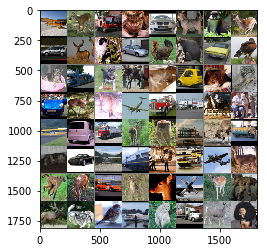

In [4]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

data_iter = iter(trainloader)
images, labels = data_iter.next()
classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

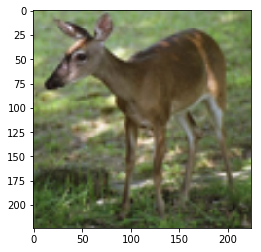

In [5]:
img_test = images[1]/2 + 0.5
npimg_test = img_test.numpy()
plt.imshow(np.transpose(npimg_test,(1,2,0)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            # 3 224 128
            nn.Conv2d(3, 64, 3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(64,64, 3, padding=1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            # 64 112 64
            nn.Conv2d(64,128, 3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128,3, padding=1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            # 128 56 32
            nn.Conv2d(128,256,3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(256,256,3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(256,256,3, padding=1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            # 256 28 16
            nn.Conv2d(256,512,3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(512,512,3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(512,512,3, padding=1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
            # 512 14 8
            nn.Conv2d(512,512,3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(512,512,3, padding=1), nn.LeakyReLU(0.2),
            nn.Conv2d(512,512,3, padding=1), nn.LeakyReLU(0.2),
            nn.MaxPool2d(2,2),
        )
        
        # 512 7 4
        self.avg_pool = nn.AvgPool2d(7)
        
        # 512 1 1
        self.classifier = nn.Linear(512, 10)
        """
        self.fc1 = nn.Linear(512*2*2, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        """
        
    def forward(self, x):
        features = self.conv(x)
        x = self.avg_pool(features)
        x = x.view(features.size(0), -1)
        x = self.classifier(x)
        return x, features

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Net()
net = net.to(device)
param = list(net.parameters())
print(len(param))
for i in param:
    print(i.shape)

28
torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [15]:
for epoch in range(100):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs, f = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if(loss.item()>1000):
            print(loss.item())
            for param in net.parameters():
                print(param.data)            
        running_loss += loss.item()
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/50))

            running_loss = 0.0

print('Finished Training')
    
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        outputs,_ = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s: %2d %%' %(
    classes[i], 100*class_correct[i]/class_total[i]))

[1,    50] loss: 1.417
[2,    50] loss: 1.355
[3,    50] loss: 1.351
[4,    50] loss: 1.315
[5,    50] loss: 1.257
[6,    50] loss: 1.222
[7,    50] loss: 1.192
[8,    50] loss: 1.196
[9,    50] loss: 1.137
[10,    50] loss: 1.097
[11,    50] loss: 1.036
[12,    50] loss: 1.014
[13,    50] loss: 0.999
[14,    50] loss: 0.990
[15,    50] loss: 0.911
[16,    50] loss: 0.917
[17,    50] loss: 0.891
[18,    50] loss: 0.813
[19,    50] loss: 0.800
[20,    50] loss: 0.798
[21,    50] loss: 0.717
[22,    50] loss: 0.733
[23,    50] loss: 0.760
[24,    50] loss: 0.668
[25,    50] loss: 0.603
[26,    50] loss: 0.608
[27,    50] loss: 0.592
[28,    50] loss: 0.494
[29,    50] loss: 0.478
[30,    50] loss: 0.456
[31,    50] loss: 0.442
[32,    50] loss: 0.425
[33,    50] loss: 0.333
[34,    50] loss: 0.382
[35,    50] loss: 0.258
[36,    50] loss: 0.347
[37,    50] loss: 0.348
[38,    50] loss: 0.175
[39,    50] loss: 0.334
[40,    50] loss: 0.209
[41,    50] loss: 0.115
[42,    50] loss: 0.137
[

In [11]:
torch.save(net, "./vgg.pth")

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


ANS: car REAL: car 0


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


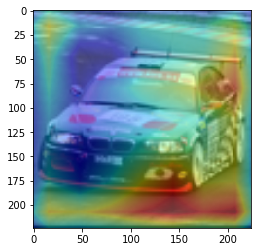

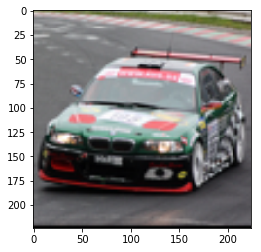

ANS: truck REAL: truck 1


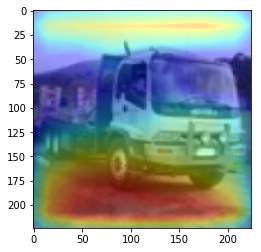

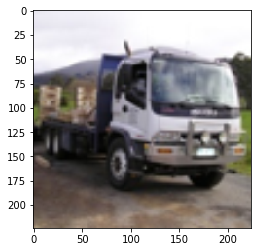

ANS: car REAL: truck 2


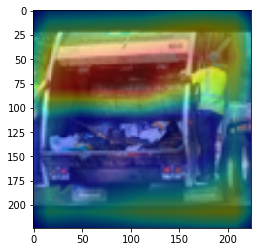

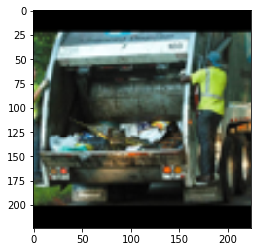

ANS: deer REAL: cat 3


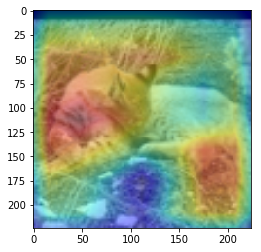

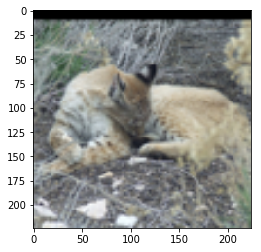

ANS: horse REAL: deer 4


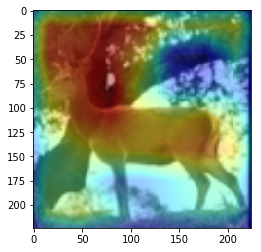

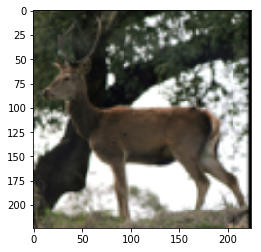

ANS: car REAL: car 5


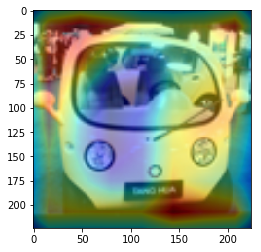

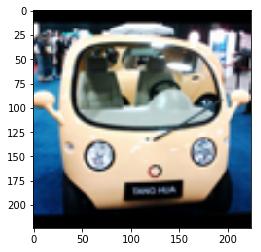

ANS: bird REAL: horse 6


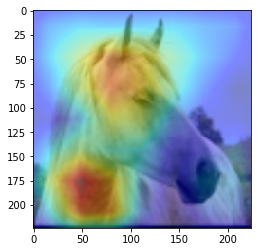

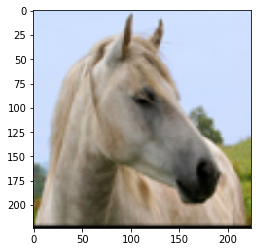

ANS: car REAL: truck 7


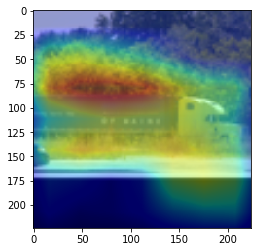

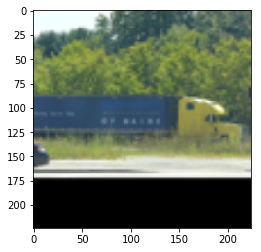

In [14]:
import skimage.transform
params = list(net.parameters())
num = 0
for num in range(8):
    print("ANS:", classes[int(predicted[num])], "REAL:", classes[int(labels[num])], num)
    
    overlay = params[-2][int(predicted[num])].matmul(f[num].reshape(512,49)).reshape(7,7).cpu().data.numpy()
    
    overlay = overlay - np.min(overlay)
    overlay = overlay / np.max(overlay)
    
    imshow(images[num].cpu())
    skimage.transform.resize(overlay, [224,224])
    plt.imshow(skimage.transform.resize(overlay,[224,224]), alpha=0.4, cmap='jet')
    plt.show()
    imshow(images[num].cpu())
    plt.show()